# 3. Fitting diads once you have groups
- Once you have divided your diads into groups based on strengths, you need to tweak the fit parameters for each group
- Then you can loop through all files in a given group and automatically fit the spectra

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import os
import DiadFit as pf
pf.__version__

'0.0.59'

## Specifying filetype, and folder as before

In [23]:
MasterFolder = r"P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Data\Hawaii_FI\Data\Raman\Leilani-2018"
DayFolder = os.path.join(MasterFolder, "Leilani_2018FI_Oct1222_postcalibration")
meta_path=DayFolder +  '\Metadata'
spectra_path=DayFolder + '\Spectra'
filetype='headless_txt'

if not os.path.exists(MasterFolder + '\OUTPUT'):
    os.mkdir(MasterFolder +'\OUTPUT')

# This specifies what file type your Raman exported in. 
filetype='headless_txt' # Specifies raman file format 
file_ext='.txt'
prefix=False

## Load in data and fit parameters
- This loads in the dataframes of the fit parameters you saved in the other file, by group
- At this point you select what group you want to fit (batch = 'Weak', 'Medium' or 'Strong'). After running through the entire notebook for one group, come back up here to fit a second group.

In [24]:
## load dataframes and numpy arrays 
np_x = joblib.load('np_x.sav')

# Select the group you want to fit ('Weak', 'Medium', 'Strong')
batch='Medium' # Options are Weak, Medium, Strong

if batch=='Weak':
    GroupN_df=joblib.load('Weak_df.sav')
if batch=='Medium':
    GroupN_df=joblib.load('Medium_df.sav')
if batch=='Strong':
    GroupN_df=joblib.load('Strong_df.sav')

In [25]:
GroupN_df

,filename,rays_present,approx_split,Diad1_pos,Diad2_pos,HB1_pos,HB2_pos,C13_pos,Diad1_abs_prom,Diad2_abs_prom,...,HB2_height,C13_height,Diad1_height,HB1_height,Diad1_Median_Bck,Diad2_Median_Bck,C13_HB2_abs_prom_ratio,Diad2_HB2_Valley_prom,HB1_prom/std_betweendiads,HB2_prom/std_betweendiads
0,LL7-107-#2-rep1.txt,False,103.579776,1284.567388,1388.147164,1264.488288,1409.799154,1369.921435,579.541169,1141.230129,...,776.669612,735.054309,1295.541169,762.449110,716.000000,707.599976,3.313436,1.000565,20.029295,34.462116
1,LL7-107-#2-rep2.txt,False,103.579776,1284.589386,1388.169163,1264.664276,1409.678163,1370.025928,767.338784,1508.005400,...,799.822132,737.056907,1480.738777,764.785916,713.399994,706.349991,3.824394,1.000708,23.775190,47.623326
2,LL7-107-#2-rep3_CRR_DiadFit.txt,True,103.585276,1284.611385,1388.196661,1264.631278,1409.700161,1370.042427,756.618577,1487.338584,...,799.903071,737.574997,1465.818590,760.949267,709.200012,703.350006,3.489249,1.008413,24.383980,49.211320
3,LL7-107-#2-rep4_CRR_DiadFit.txt,True,103.563277,1284.644382,1388.207660,1264.202308,1409.694661,1370.003930,726.784689,1410.977823,...,799.781199,741.541390,1437.884695,755.716238,711.100006,704.799988,3.420054,0.999858,21.714380,50.791776
4,LL7-107-#2-rep5_CRR_DiadFit.txt,True,103.552278,1284.682880,1388.235158,1264.532285,1409.612167,1369.932434,698.814626,1376.017421,...,790.788577,729.017416,1408.014638,759.039413,709.200012,702.899994,4.559858,1.004414,21.758067,41.928738


### Now load one file from this group to tweak parameters for

In [26]:
Diad_Files =GroupN_df['filename']
i=0
Diad_Files[i]

'LL7-107-#2-rep1.txt'

### Lets plot the diad to have a look at it

LL7-107-#2-rep1.txt


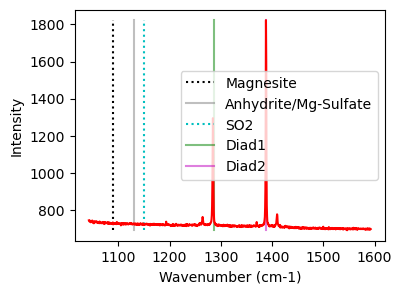

In [27]:
print(GroupN_df['filename'].iloc[i])
plot1=pf.plot_diad(path=spectra_path, filename=Diad_Files[i], filetype=filetype)

## Now lets inspect the diads and get their approximate positions
- As with generic peak, you can exclude 2 segments (e.g. around cosmic rays)
- You then specify how many peaks you want to fit on each diad. 1 means just the strong peak, 2 hotbands, and 3 for Diad2 would also fit the C13 peak if present. 
- The identify_diad_peaks then uses scipy findpeaks to identify the positions of the 2 diads, and any other peaks the user asks for. These are saved, and fed into the later functions for peak fitting. 

## Choose a model for fitting all peaks
- Option of Voigt or PseudoVoigt. We recomend PsuedoVoigt

In [28]:
model_name='PseudoVoigtModel'

## Fit Diad 1
- Tweak the parameters in the config files for each group. E.g. how many peaks (fit_peaks), the background positions, the sigma of the diad, and whether or not you want a gaussian background

In [29]:
diad_id_config=pf.diad_id_config(height=50, exclude_range1=[1308, 1309])
diad_id_config

if batch=='Weak':
    diad1_fit_config_init=pf.diad1_fit_config(
    model_name=model_name, fit_peaks=1,
    N_poly_bck_diad1=2, lower_bck_diad1=(1180, 1250),
    upper_bck_diad1=(1300, 1350),
    diad_sigma=0.6,
    x_range_residual=10, x_range_baseline=30, 
     y_range_baseline=100, 
    HB_prom=GroupN_df['HB1_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i])
    diad1_fit_config_init

if batch=='Medium':
    diad1_fit_config_init=pf.diad1_fit_config(
    model_name=model_name, fit_peaks=2,
    N_poly_bck_diad1=2, lower_bck_diad1=(1180, 1220),
    upper_bck_diad1=(1330, 1350),
    diad_sigma=0.6,
    x_range_residual=10, x_range_baseline=30, 
     y_range_baseline=100, 
    HB_prom=GroupN_df['HB1_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i])
    diad1_fit_config_init

if batch=='Strong':
    diad1_fit_config_init=pf.diad1_fit_config(
    fit_gauss=True, gauss_amp= 2*GroupN_df['HB1_abs_prom'].iloc[i],
    model_name=model_name, fit_peaks=2,
    N_poly_bck_diad1=1, lower_bck_diad1=(1180, 1220),
    upper_bck_diad1=(1330, 1350),
    diad_sigma=0.6,
    x_range_residual=10, x_range_baseline=30, 
     y_range_baseline=1000, 
    HB_prom=GroupN_df['HB1_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i])
diad1_fit_config_init

diad1_fit_config(model_name='PseudoVoigtModel', fit_peaks=2, N_poly_bck_diad1=2, lower_bck_diad1=(1180, 1220), upper_bck_diad1=(1330, 1350), fit_gauss=False, gauss_amp=1000, diad_sigma=0.6, diad_sigma_min_allowance=0.2, diad_sigma_max_allowance=5, diad_prom=579.5411686370148, HB_prom=43.04908523990275, x_range_baseline=30, y_range_baseline=100, dpi=200, x_range_residual=10, return_other_params=False)

### See what these fit parameters look like for diad1

refit attempt 1


,Diad1_Combofit_Cent,Diad1_Voigt_Cent,Diad1_cent_err,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Voigt_Gamma,Diad1_Combofit_Height,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit
0,1284.543617,1284.543617,0.007063,1311.009454,0.827837,0,575.693293,3.616408,0.708256,1.655673,Flagged Warnings:


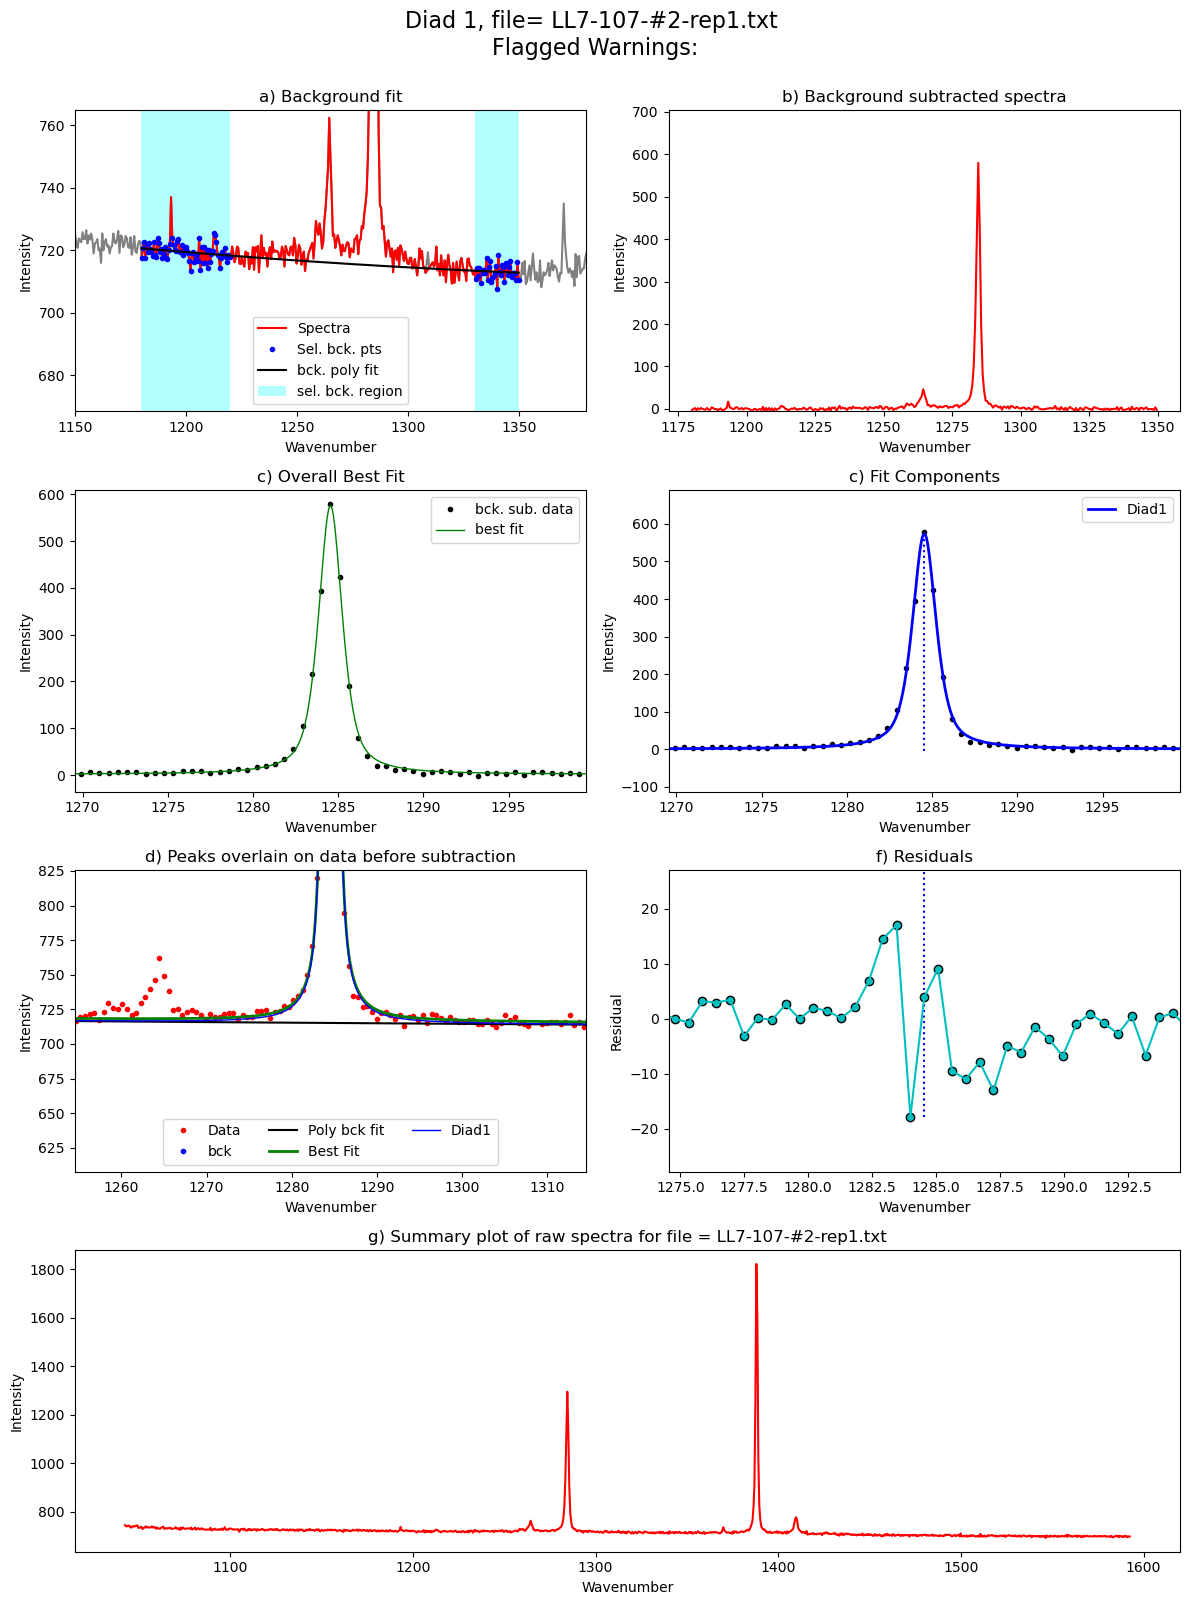

In [30]:
Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config_init,
config2=diad_id_config,
path=spectra_path, filename=GroupN_df['filename'].iloc[i],
filetype=filetype, plot_figure=True, close_figure=False,
Diad_pos=GroupN_df['Diad1_pos'].iloc[i],
HB_pos=GroupN_df['HB1_pos'].iloc[i])
Diad1_fit

### Update the sigma
- The sigma parameter varies quite a lot based on the splitting. Best to update your first guess with what you found for the example file above

In [31]:
diad1_fit_config2=diad1_fit_config_init
diad1_fit_config2.diad_sigma=Diad1_fit['Diad1_Voigt_Sigma'][0]

## Fit diad2

In [32]:
if batch=='Weak':
    diad2_fit_config_init=pf.diad2_fit_config(model_name=model_name,
    fit_peaks=1, upper_bck_diad2=(1430, 1480),
    lower_bck_diad2=(1310, 1360), diad_sigma=0.6,  N_poly_bck_diad2=2,                                       
    x_range_residual=30, y_range_baseline=100,  
    x_range_baseline=30,
    HB_prom=GroupN_df['HB2_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i])
    diad2_fit_config_init

if batch=='Medium':
    diad2_fit_config_init=pf.diad2_fit_config(model_name=model_name,
    fit_peaks=3,
    lower_bck_diad2=(1310, 1350), diad_sigma=1,  N_poly_bck_diad2=2,                                       
    x_range_residual=30, y_range_baseline=100,  
    x_range_baseline=30,
    HB_prom=GroupN_df['HB2_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i],
    C13_prom=GroupN_df['C13_abs_prom'].iloc[i])
    diad2_fit_config_init

if batch=='Strong':
    diad2_fit_config_init=pf.diad2_fit_config(model_name=model_name,
    fit_peaks=3, fit_gauss=True, gauss_amp= 2*GroupN_df['HB2_abs_prom'].iloc[i],
    lower_bck_diad2=(1310, 1340), diad_sigma=1,  N_poly_bck_diad2=2,                                       
    x_range_residual=30, y_range_baseline=1000,  
    x_range_baseline=30,
    HB_prom=GroupN_df['HB2_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i],
    C13_prom=GroupN_df['C13_abs_prom'].iloc[i])
    diad2_fit_config_init
diad2_fit_config_init

diad2_fit_config(model_name='PseudoVoigtModel', fit_peaks=3, N_poly_bck_diad2=2, lower_bck_diad2=(1310, 1350), upper_bck_diad2=(1440, 1470), fit_gauss=False, gauss_amp=1000, diad_sigma=1, diad_sigma_min_allowance=0.2, diad_sigma_max_allowance=5, diad_prom=1141.230128826624, HB_prom=74.06963646012252, x_range_baseline=30, y_range_baseline=100, plot_figure=True, dpi=200, x_range_residual=30, return_other_params=False, C13_prom=22.35432721265181)

### See what these fit parameters look like for diad2

In [33]:
Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config_init,
    config2=diad_id_config,
path=spectra_path, filename=GroupN_df['filename'].iloc[i], filetype=filetype,
plot_figure=True, close_figure=True, 
Diad_pos=GroupN_df['Diad2_pos'].iloc[i],
HB_pos=GroupN_df['HB2_pos'].iloc[i], 
C13_pos=GroupN_df['C13_pos'].iloc[i])
Diad2_fit.to_clipboard(excel=True)
Diad2_fit

,Diad2_Combofit_Cent,Diad2_Voigt_Cent,Diad2_cent_err,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,HB2_Cent,HB2_Area,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Combofit_Height,Diad2_Residual,Diad2_Prop_Lor,Diad2_fwhm,Diad2_refit
0,1388.172321,1388.172271,0.001987,2030.12219,0.638465,0,1409.673628,241.73108,1.098429,1369.806,30.036012,0.318926,1169.502684,2.966219,0.673508,1.27693,Flagged Warnings:


### Update the sigma

In [34]:
diad2_fit_config2=diad2_fit_config_init
diad2_fit_config2.diad_sigma=Diad2_fit['Diad2_Voigt_Sigma'][0]
print(Diad2_fit['Diad2_Voigt_Sigma'][0])

0.6384650629936007


## Loop over all the files in the group
- This will loop over all the 

  0%|          | 0/5 [00:00<?, ?it/s]

refit attempt 1


100%|██████████| 5/5 [00:16<00:00,  3.31s/it]


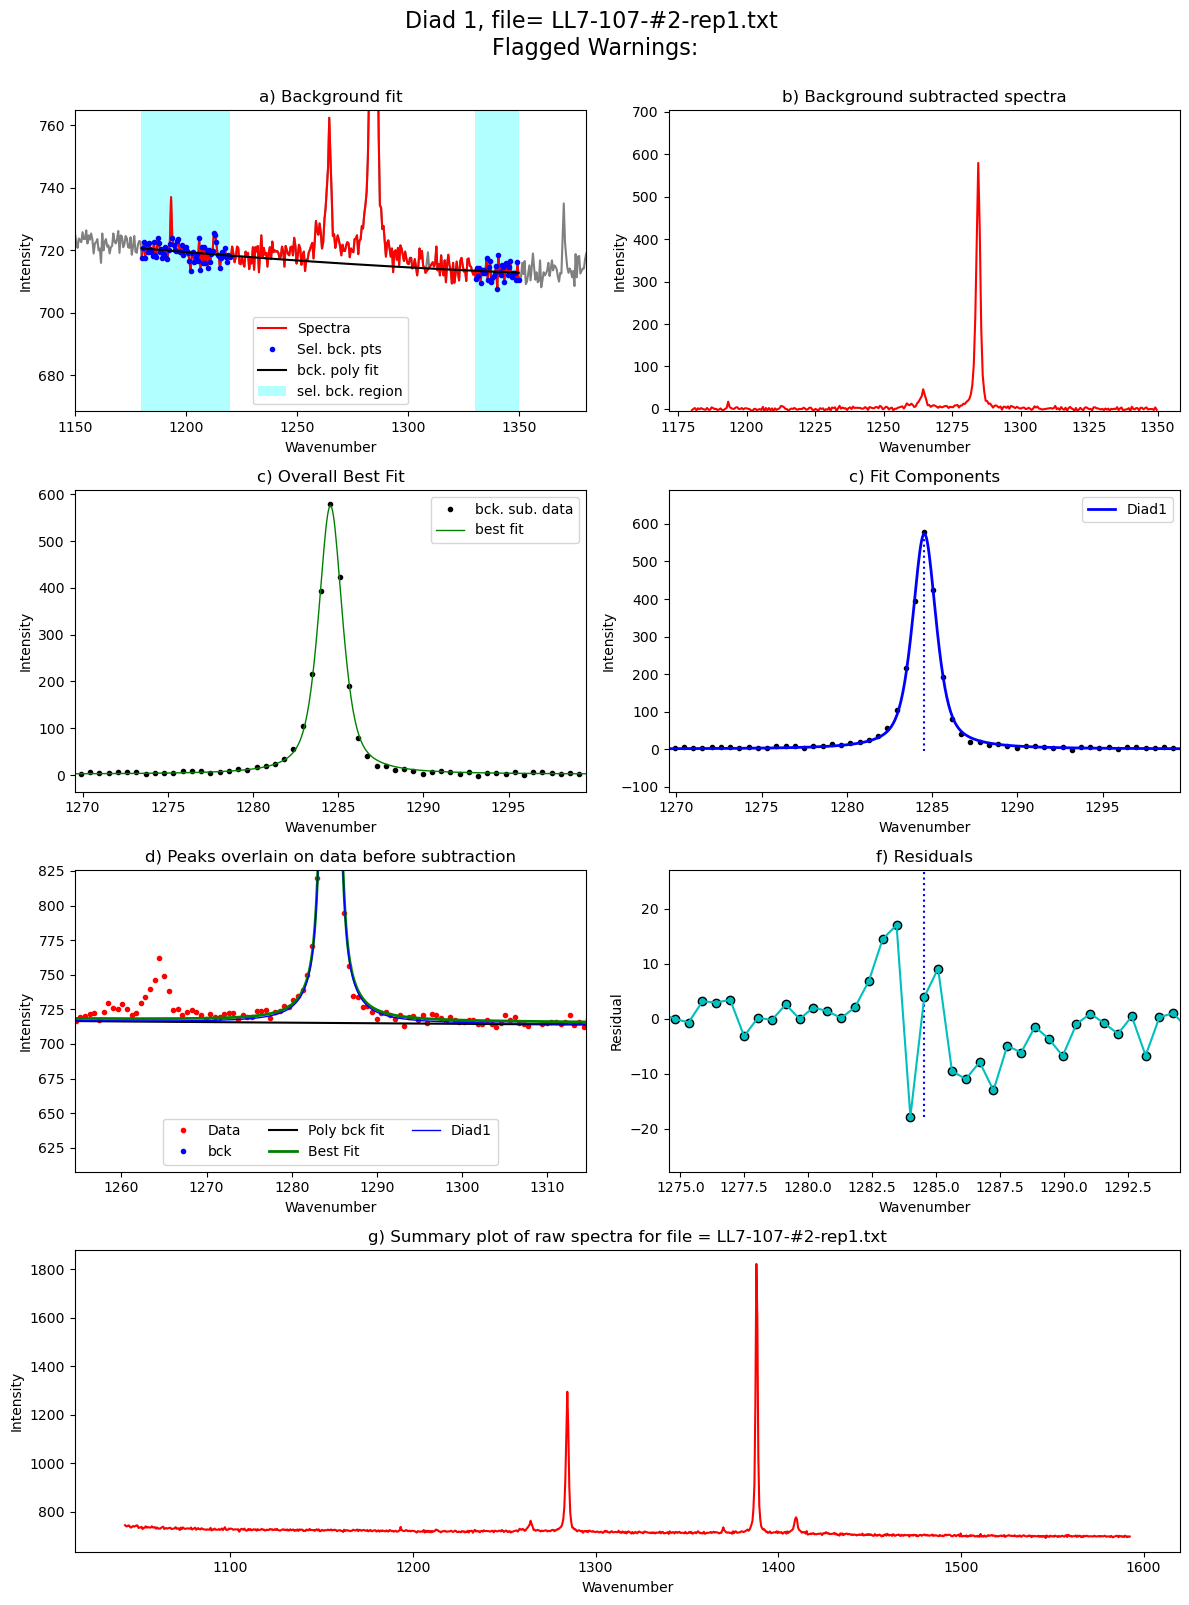

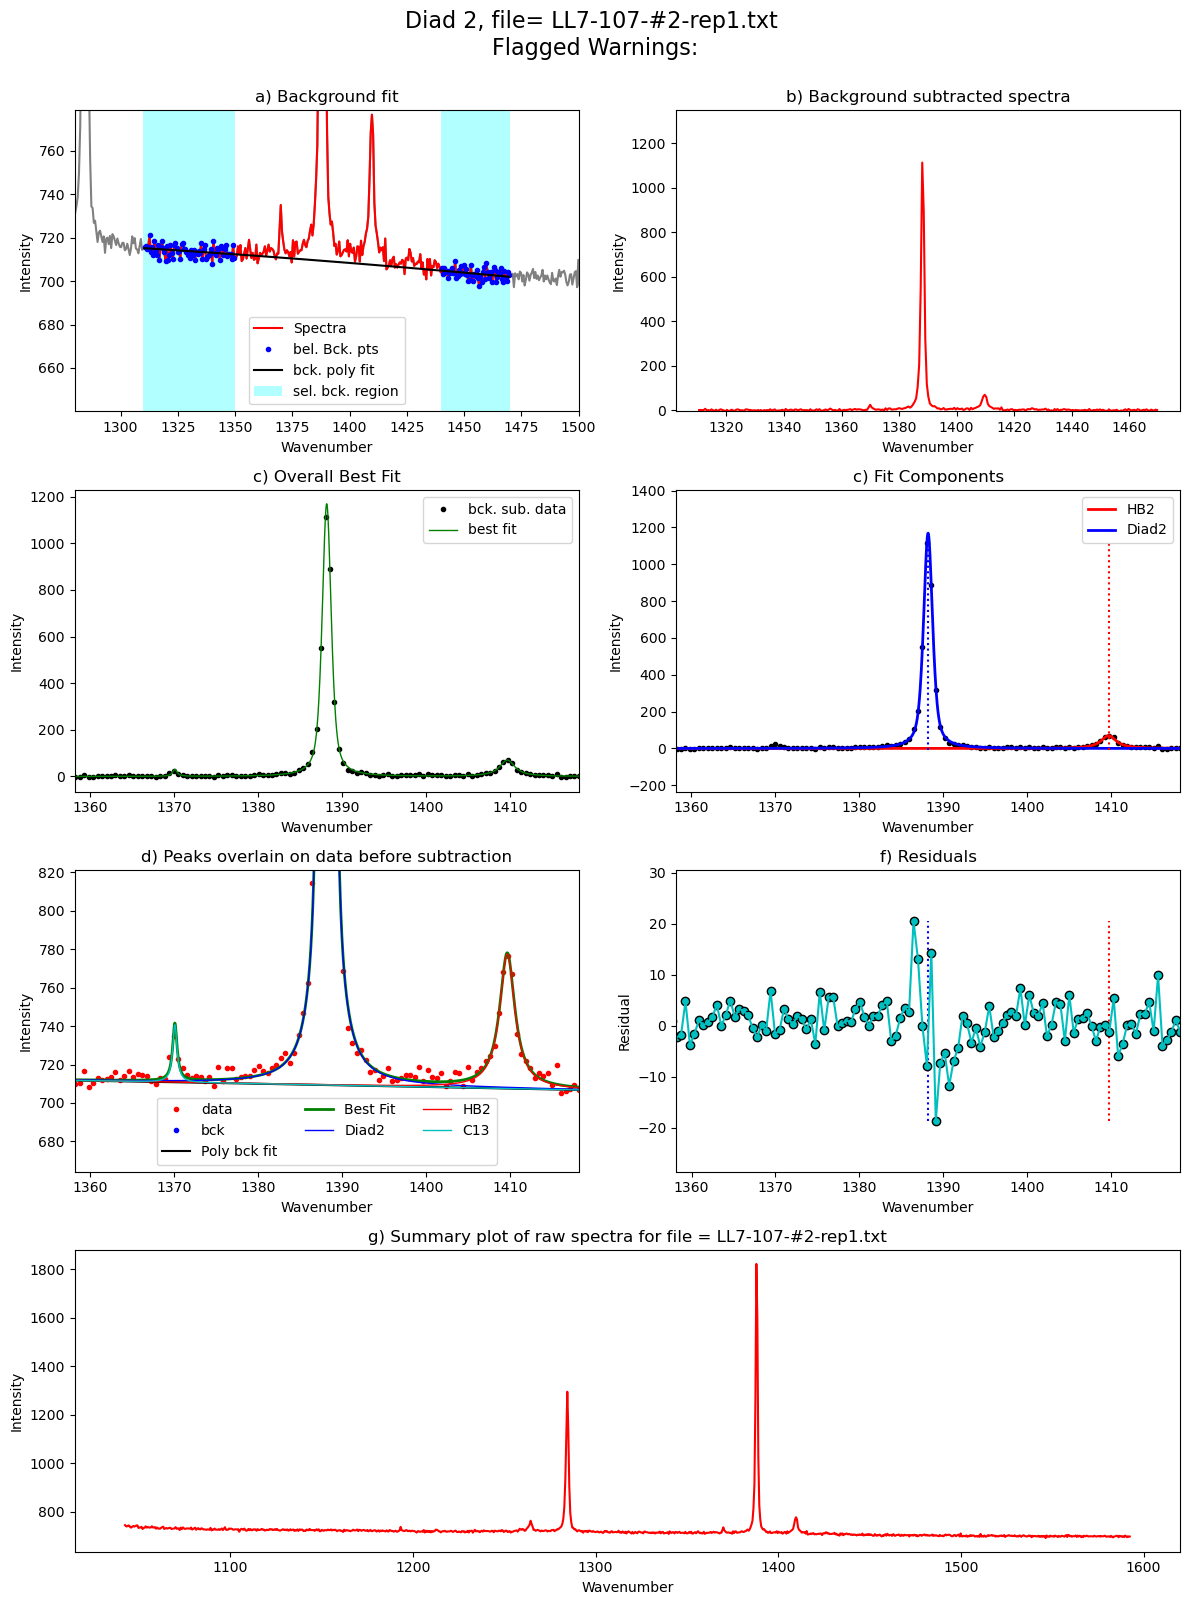

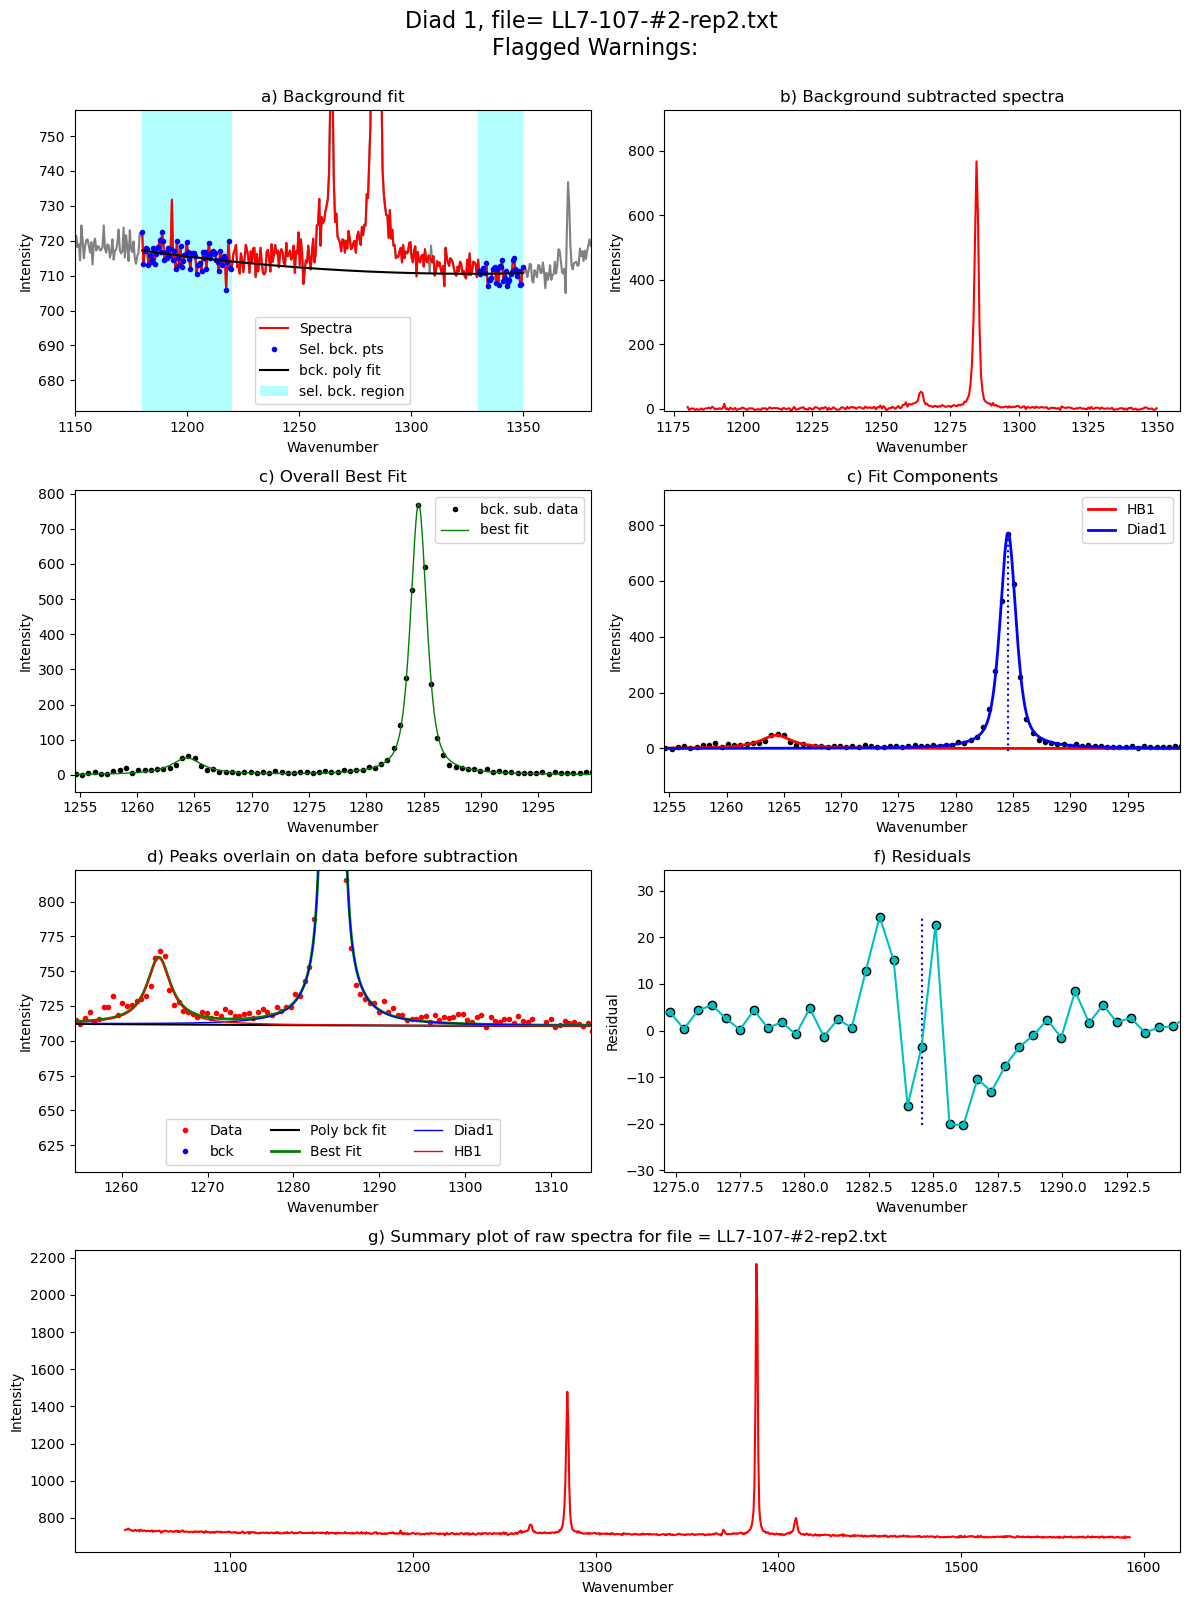

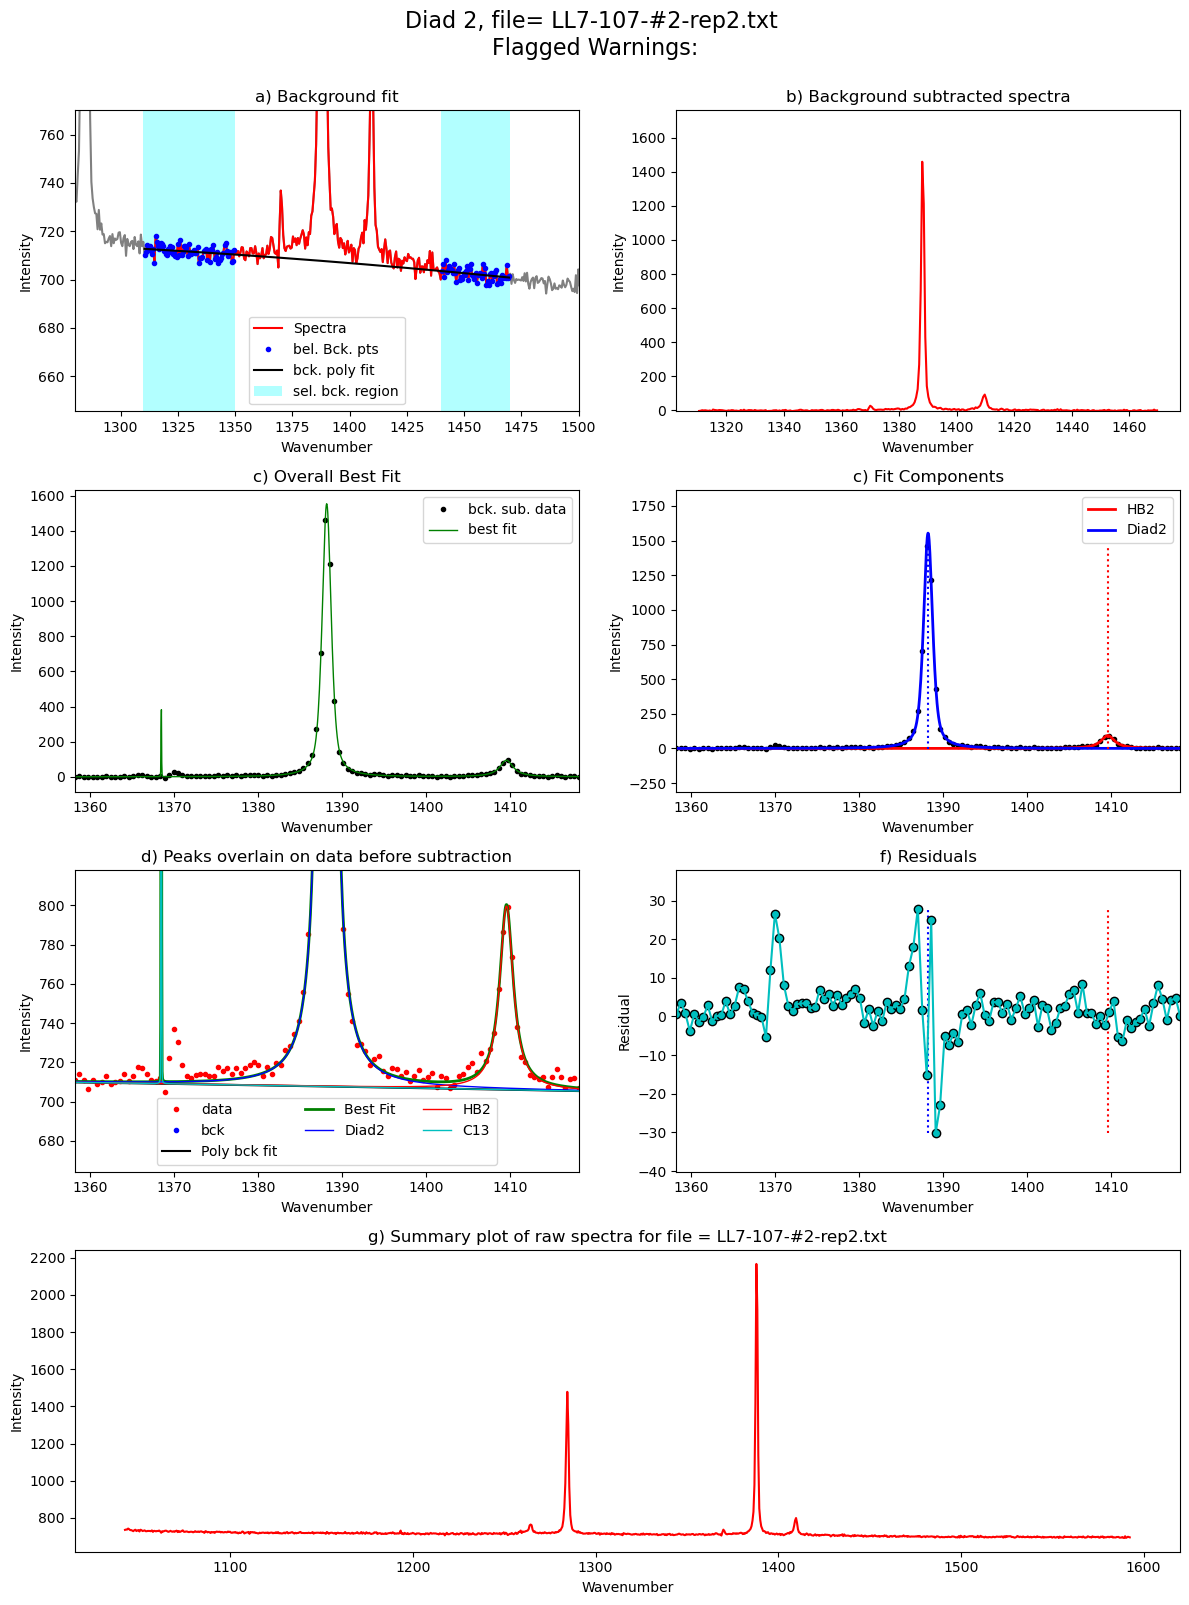

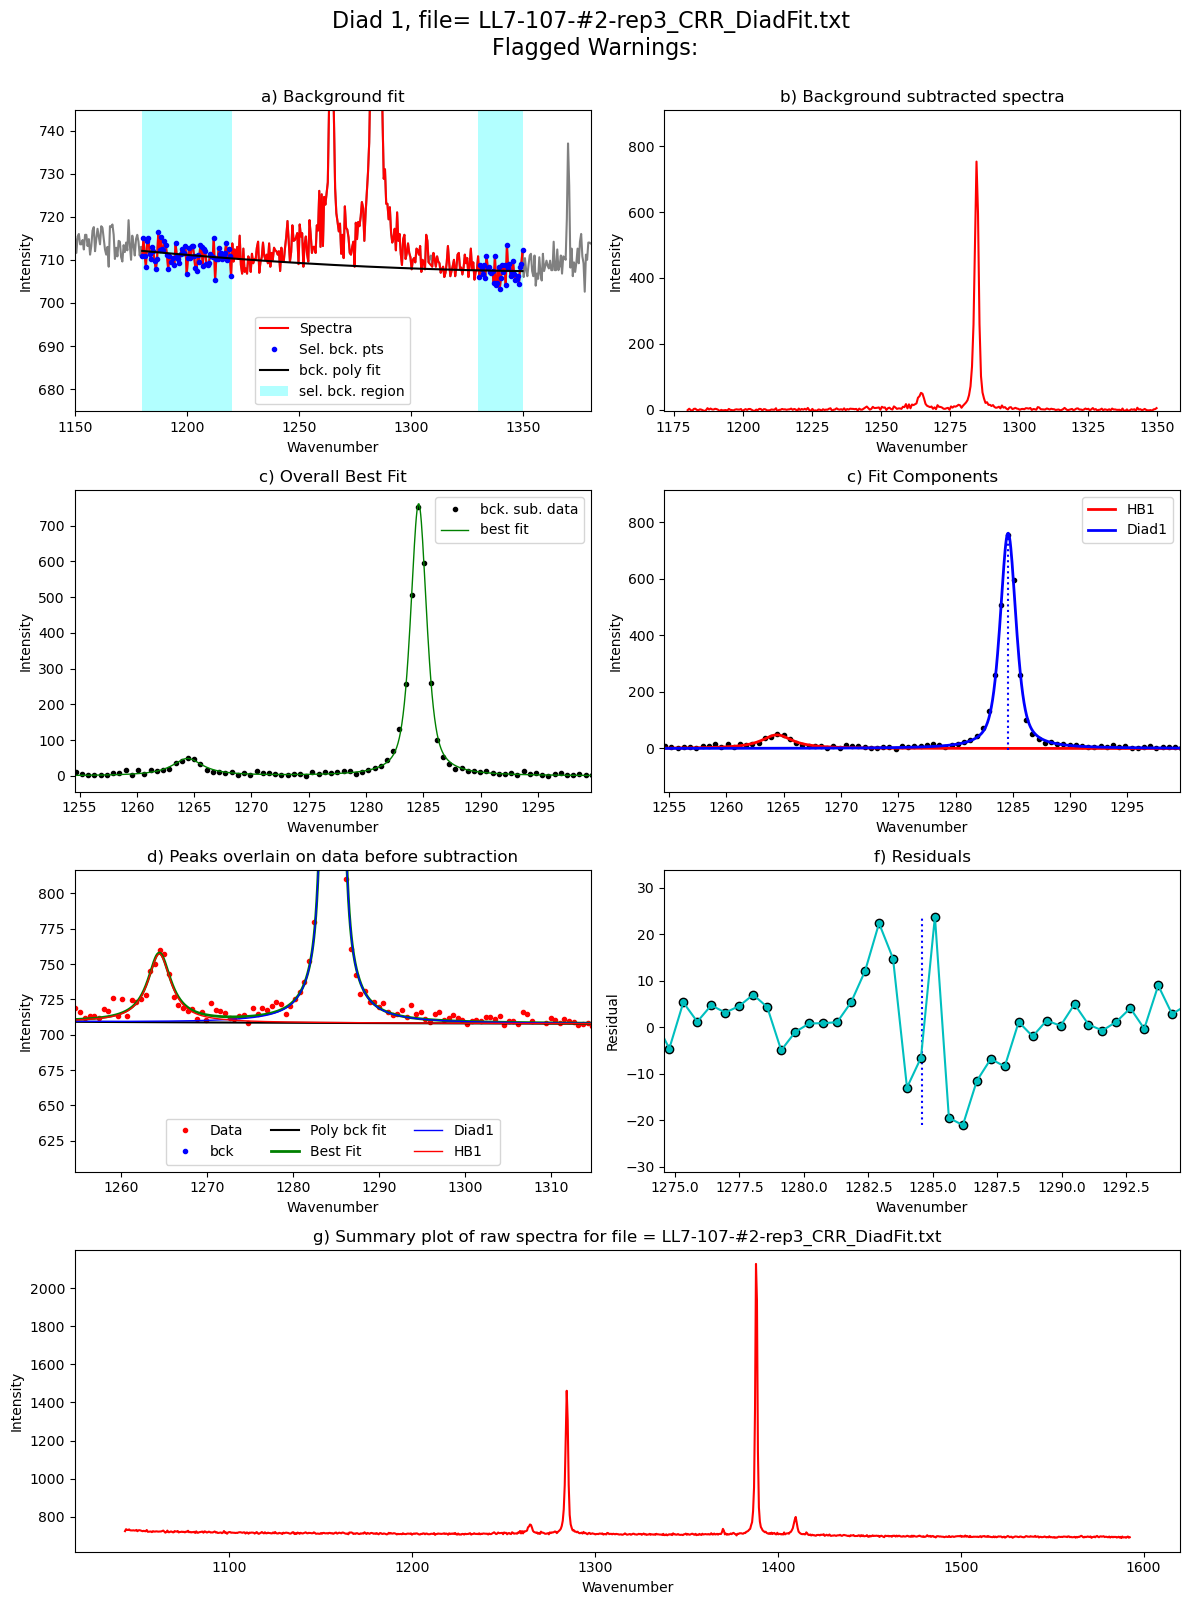

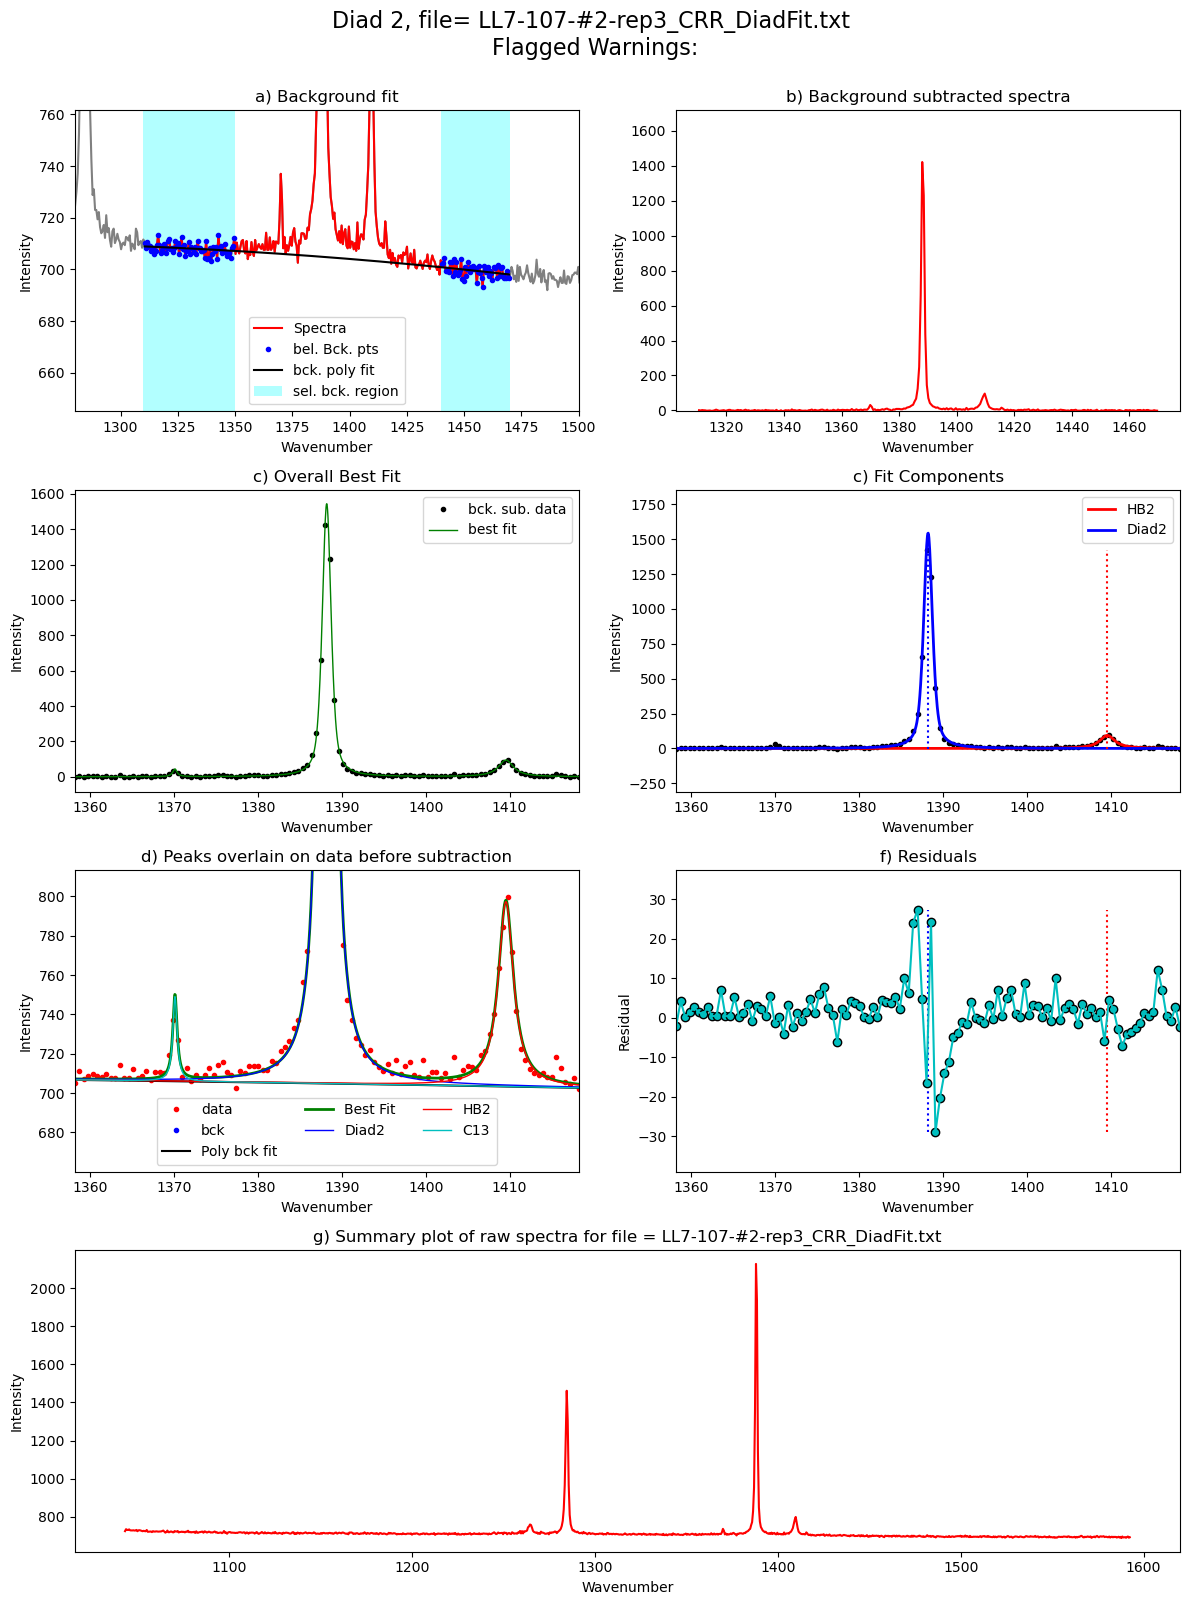

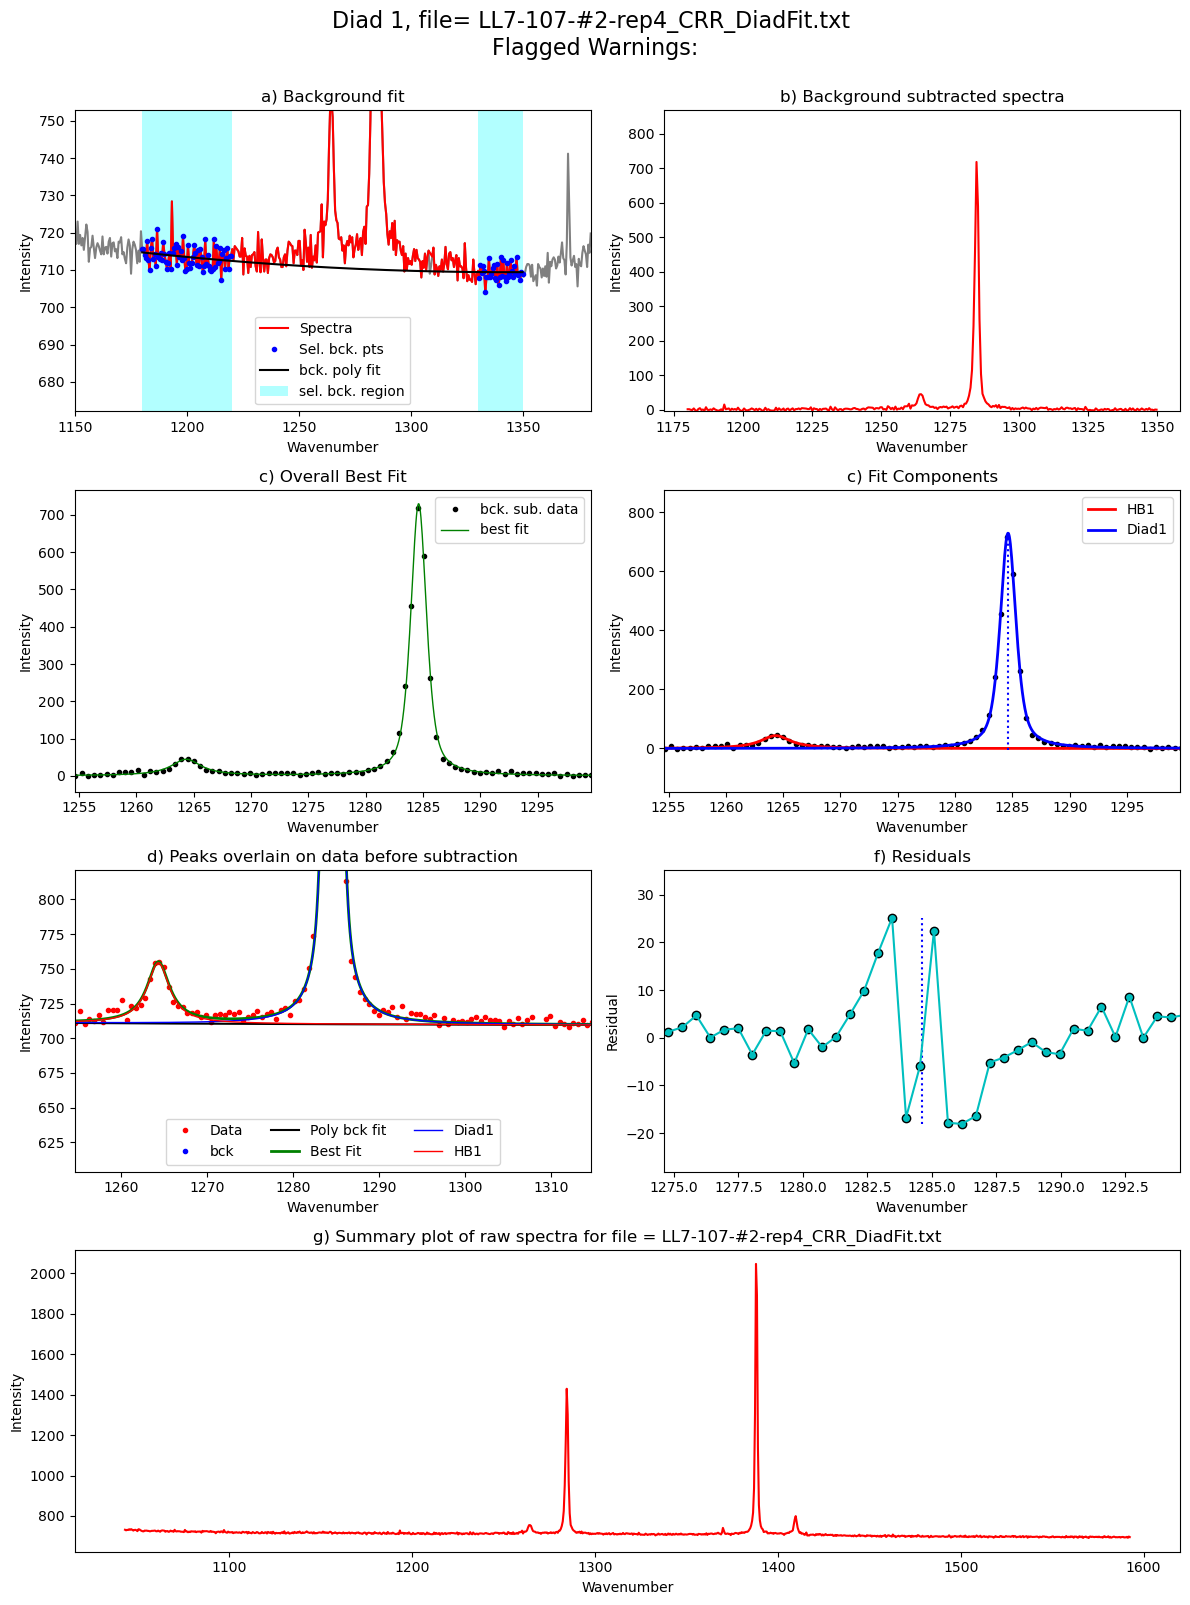

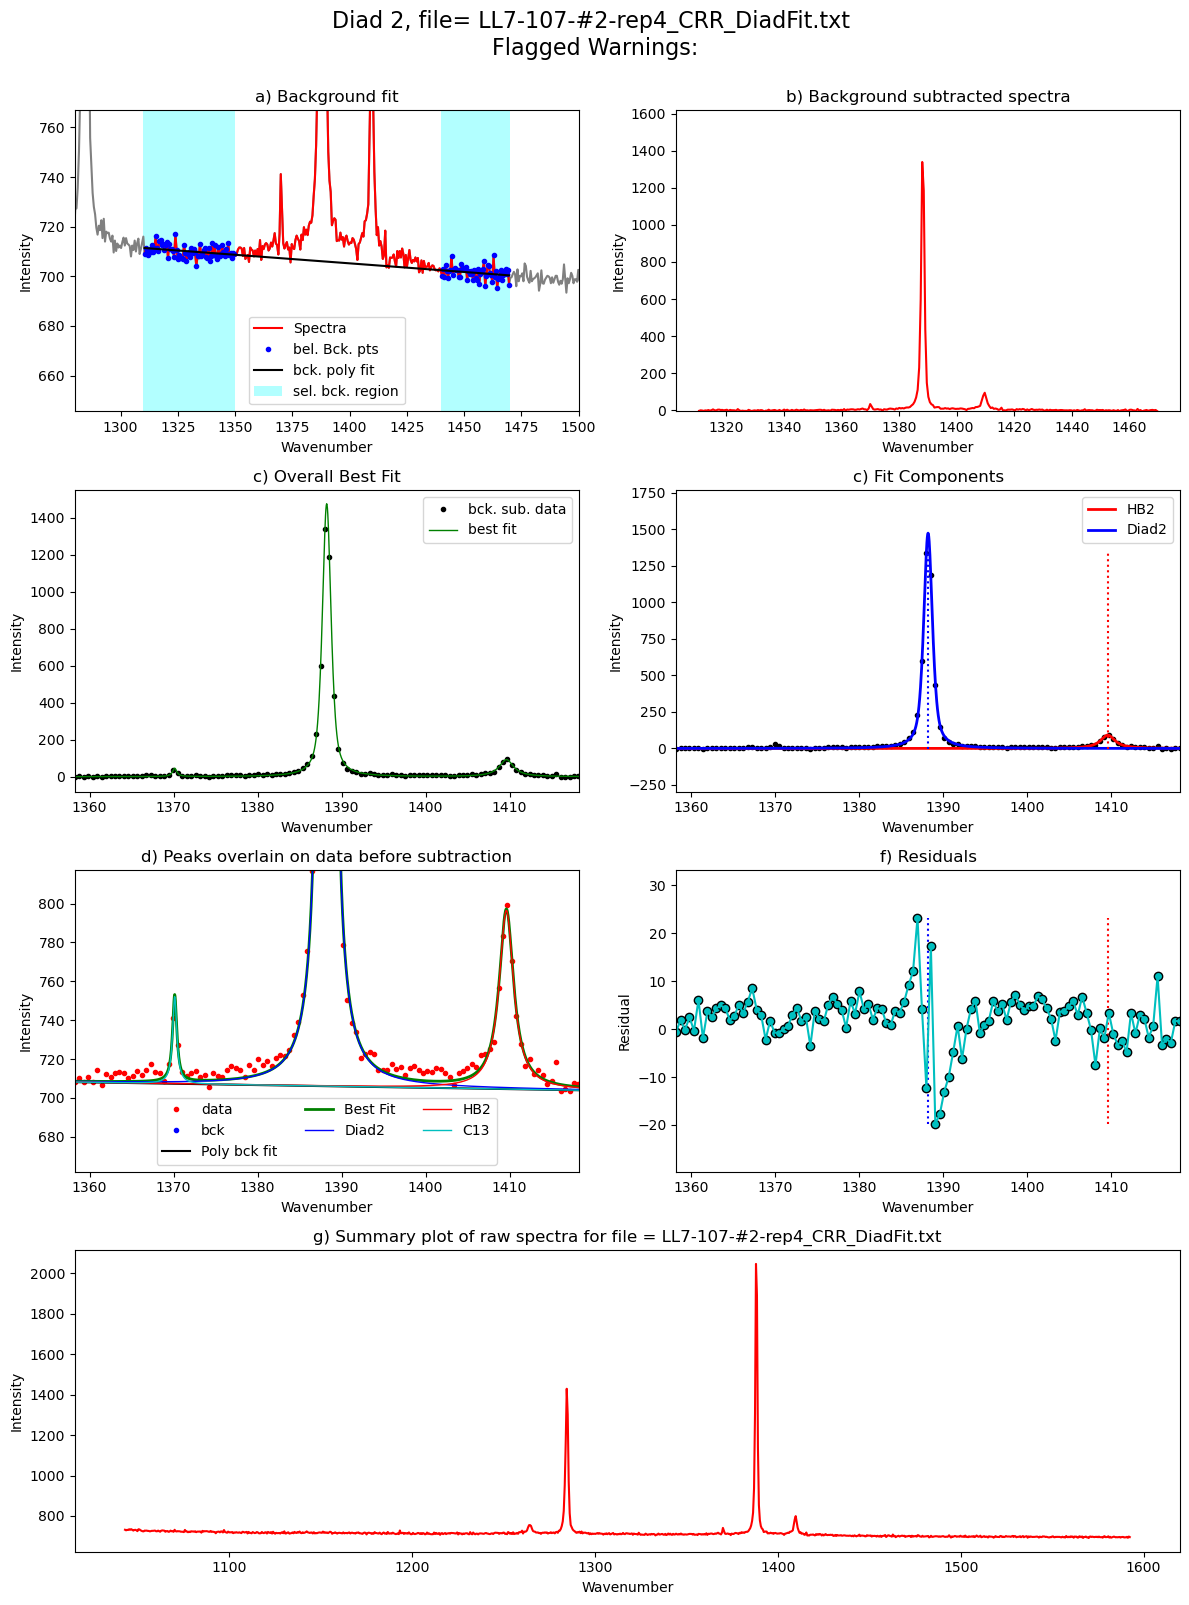

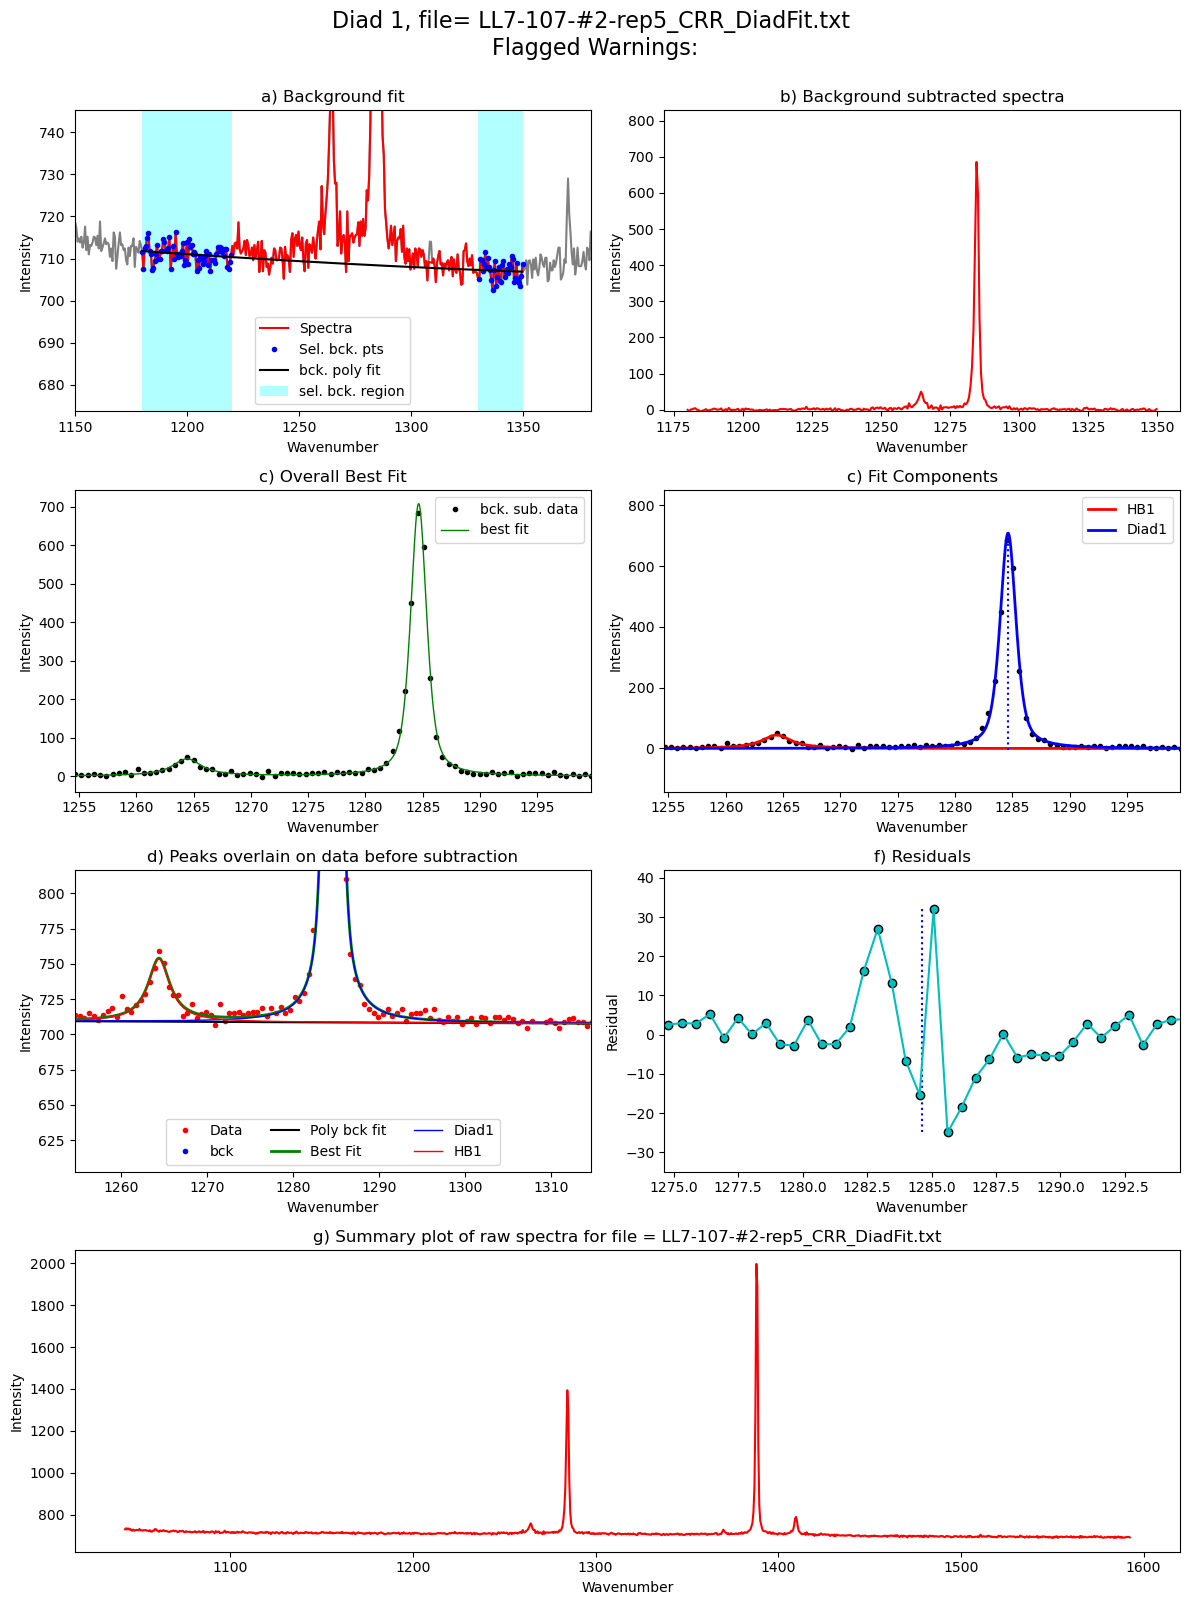

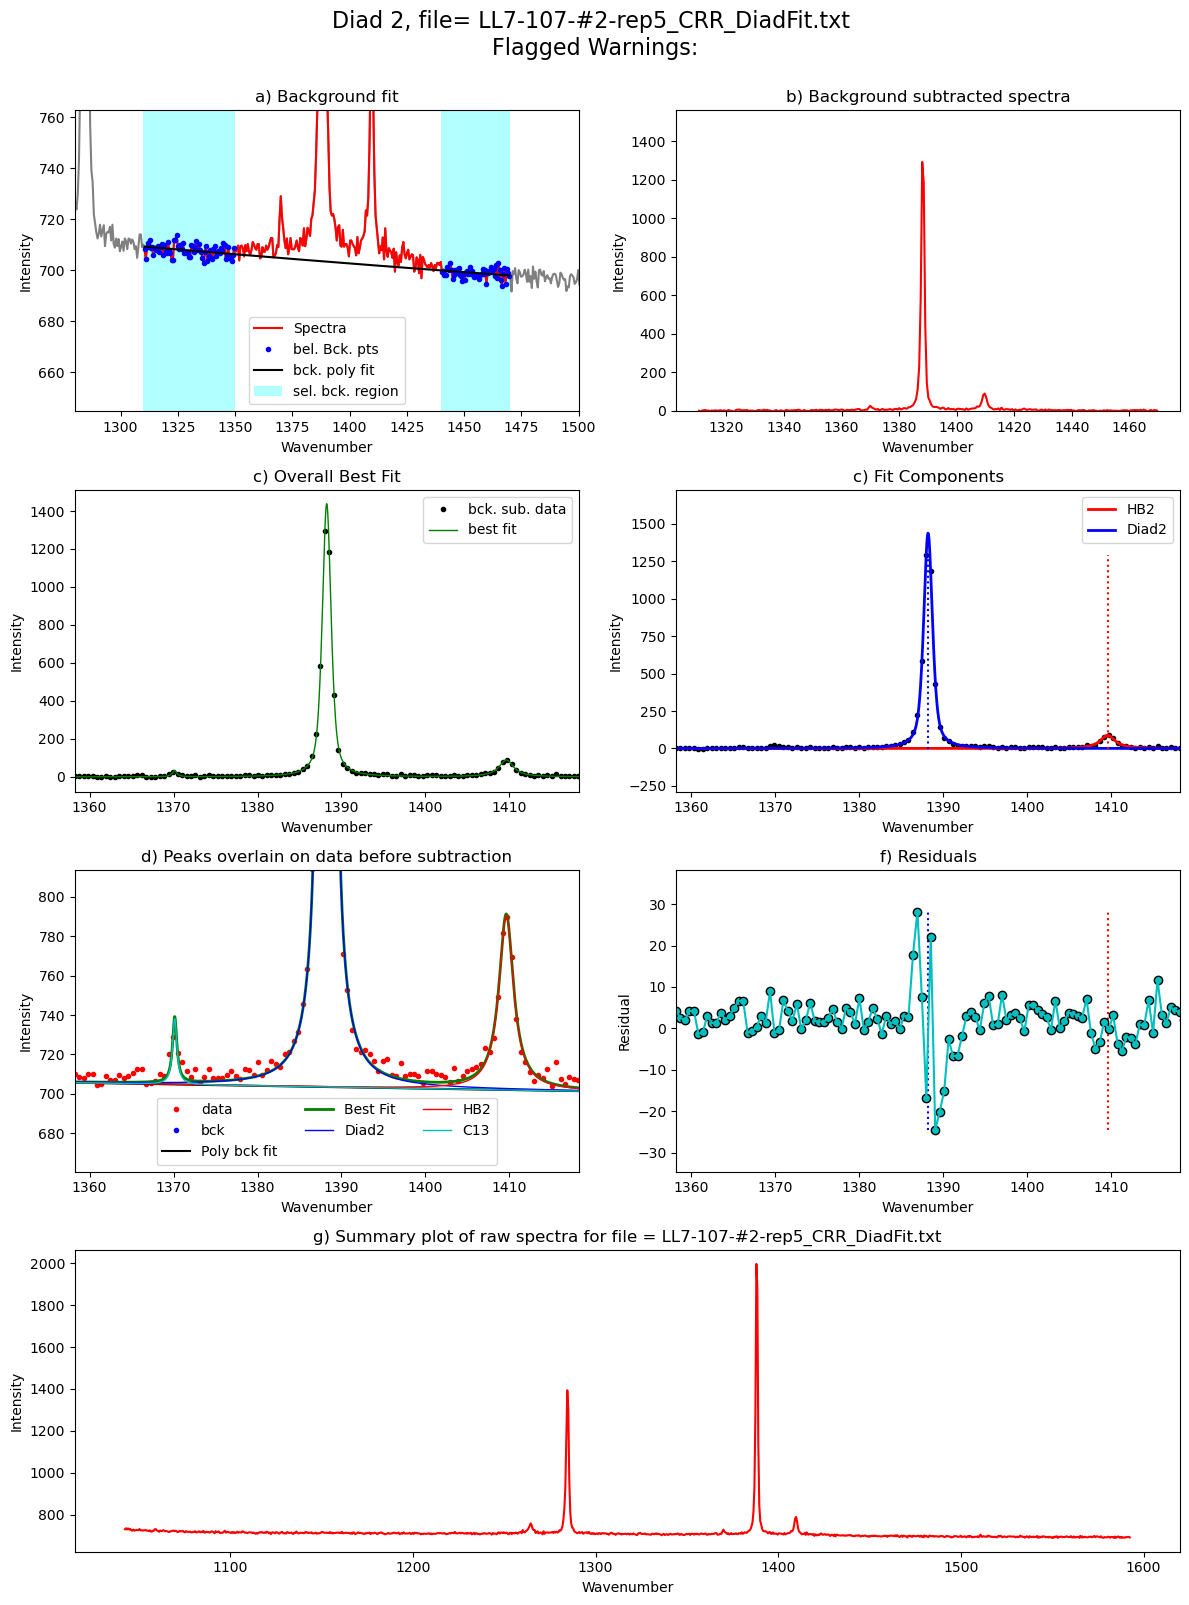

In [35]:
from tqdm import tqdm
plot_figure=True # If False, Means doesnt have to make figures, lot faster. 
close_figure=False # If True, wont show figures in notebook, but will still save them in a folder 
Diad_Files_i=Diad_Files
df_Merge = pd.DataFrame([])
for i in tqdm(range(0, len(Diad_Files))): #
    
    # For diad1, config file like you had in the previous. 
    # Only really used to exclude a range (say your spectra has a known spec)
    diad_id_config=pf.diad_id_config(exclude_range1=[1308, 1309])
    
    # Here, the prominence are taken from the fitting in the last notebook
    diad1_fit_config2.HB_prom=GroupN_df['HB1_abs_prom'].iloc[i]
    diad1_fit_config2.diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i]
    diad1_fit_config2.gauss_amp=2*GroupN_df['HB1_abs_prom'].iloc[i]

    Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config2,
    config2=diad_id_config, path=spectra_path, filename=GroupN_df['filename'].iloc[i],
    filetype=filetype, plot_figure=plot_figure, close_figure=close_figure,
    Diad_pos=GroupN_df['Diad1_pos'].iloc[i],
    HB_pos=GroupN_df['HB1_pos'].iloc[i])

    ## Same for diad2, just also has a C13 peak
    diad2_fit_config2.HB_prom=GroupN_df['HB2_abs_prom'].iloc[i]
    diad2_fit_config2.diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i]
    diad2_fit_config2.gauss_amp= 2*GroupN_df['HB2_abs_prom'].iloc[i]
    diad2_fit_config2.C13_prom=GroupN_df['C13_abs_prom'].iloc[i]
    
    
    Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config2,
        config2=diad_id_config,
    path=spectra_path, filename=GroupN_df['filename'].iloc[i], 
    filetype=filetype,
    plot_figure=plot_figure, close_figure=close_figure,
    Diad_pos=GroupN_df['Diad2_pos'].iloc[i],
    HB_pos=GroupN_df['HB2_pos'].iloc[i], 
    C13_pos=GroupN_df['C13_pos'].iloc[i])
    
    # This combines the outputs into a single dataframe
    data=pf.combine_diad_outputs(filename=GroupN_df['filename'].iloc[i], prefix=False, 
    Diad1_fit=Diad1_fit, path=spectra_path,                  
    Diad2_fit=Diad2_fit)        
    
 

    df_Merge = pd.concat([df_Merge, data], axis=0)


### Get file names that flagged a warning

In [36]:
refit_d1=(df_Merge['Diad1_refit']!='Flagged Warnings:')
refit_d2=(df_Merge['Diad2_refit']!='Flagged Warnings:')# (df_Merge['Diad2_refit']==True)
refit=refit_d1|refit_d2
print(sum(refit))
refit_names_1=df_Merge['filename'].loc[refit]
print(refit_names_1)

0
Series([], Name: filename, dtype: object)


### Have a look at different parameters
- This can help you spot really bad fits

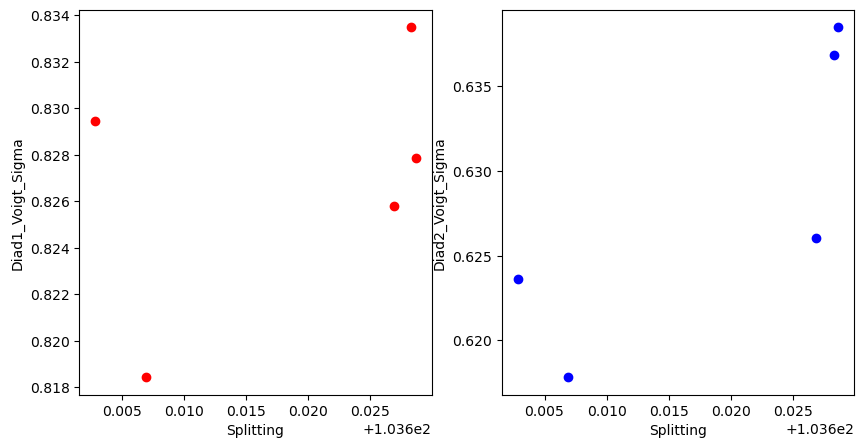

In [37]:
x='Splitting'
y1='Diad1_Voigt_Sigma'
y2='Diad2_Voigt_Sigma'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(df_Merge[x], df_Merge[y1], 'or')
ax2.plot(df_Merge[x], df_Merge[y2], 'ob')
ax1.plot(df_Merge[x].loc[refit_d1], df_Merge[y1].loc[refit_d1], 'xk', ms=10)
ax2.plot(df_Merge[x].loc[refit_d2], df_Merge[y2].loc[refit_d2], 'xk', ms=10)
ax1.set_xlabel(x)
ax2.set_xlabel(x)
ax1.set_ylabel(y1)
ax2.set_ylabel(y2)
df_not_too_Weak=df_Merge #.loc[(df_Merge['Diad1_Voigt_Area']>25) & (df_Merge['Diad2_Voigt_Area']>30)]

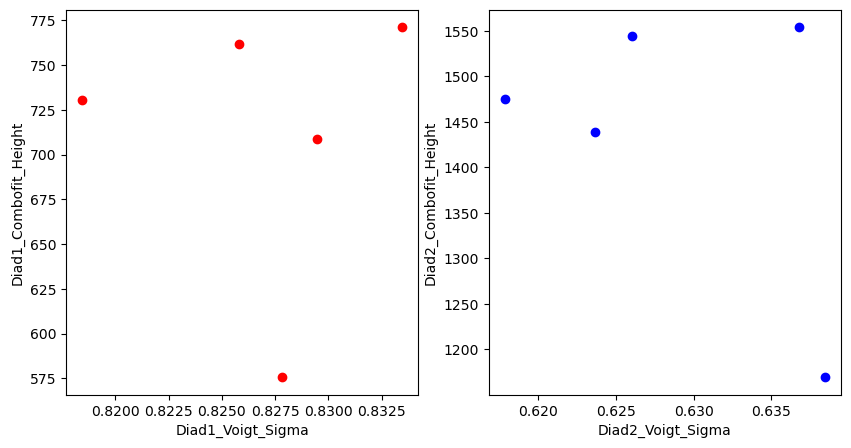

In [38]:
x1='Diad1_Voigt_Sigma'
x2='Diad2_Voigt_Sigma'
y1='Diad1_Combofit_Height'
y2='Diad2_Combofit_Height'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(df_Merge[x1], df_Merge[y1], 'or')
ax2.plot(df_Merge[x2], df_Merge[y2], 'ob')
ax1.plot(df_Merge[x1].loc[refit_d1], df_Merge[y1].loc[refit_d1], 'xk', ms=10)
ax2.plot(df_Merge[x2].loc[refit_d2], df_Merge[y2].loc[refit_d2], 'xk', ms=10)

ax1.set_xlabel(x1)
ax1.set_ylabel(y1)
ax2.set_xlabel(x2)
ax2.set_ylabel(y2)
df_not_too_Weak=df_Merge #.loc[(df_Merge['Diad1_Voigt_Area']>25) & (df_Merge['Diad2_Voigt_Area']>30)]

In [39]:
## Save parameters to excel

In [40]:
combo=df_Merge

if batch=='Weak':
    combo.to_excel('Weak_Diads.xlsx')
if batch=='Medium':
    combo.to_excel('Medium_Diads.xlsx')
if batch=='Strong':
    combo.to_excel('Strong_Diads.xlsx')

In [41]:
combo.head()

,filename,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,...,HB2_Sigma,C13_Cent,C13_Area,C13_Sigma,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad1_Gauss_Cent,Diad1_Gauss_Area,Diad1_Gauss_Sigma
0,LL7-107-#2-rep1,103.628655,0.009013,0.007302,1284.543615,0.007027,575.691859,1284.543615,1311.007355,0.827841,...,1.098416,1370.091876,30.009985,0.318927,NaN,NaN,NaN,NaN,NaN,NaN
0,LL7-107-#2-rep2,103.628287,0.005924,0.004413,1284.560590,0.003945,771.219201,1284.560640,1771.617590,0.833477,...,0.975198,1368.490141,34.786739,0.037538,NaN,NaN,NaN,NaN,NaN,NaN
0,LL7-107-#2-rep3_CRR_DiadFit,103.626889,0.005169,0.003821,1284.584782,0.003372,761.569881,1284.584832,1723.985867,0.825793,...,1.091945,1370.143479,42.387610,0.312622,NaN,NaN,NaN,NaN,NaN,NaN
0,LL7-107-#2-rep4_CRR_DiadFit,103.606917,0.006155,0.004774,1284.621294,0.004464,730.464900,1284.621344,1636.842903,0.818441,...,1.043080,1370.127888,43.396611,0.308472,NaN,NaN,NaN,NaN,NaN,NaN
0,LL7-107-#2-rep5_CRR_DiadFit,103.602868,0.006644,0.005120,1284.635752,0.004760,708.814387,1284.635802,1587.036052,0.829468,...,1.052881,1370.141270,32.769998,0.311360,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
from winotify import Notification, audio

toast= Notification(app_id="VSCode",title="Notebook completed",
                    msg="Step3_FitAll_Together is done!",
                    duration="short")
toast.set_audio(audio.Mail,loop=False)
toast.show()